In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import exp
from pyspark.sql.functions import max,sum,count
from pyspark.ml.classification import LogisticRegression  
import matplotlib.pyplot as plt
import numpy as np
spark = SparkSession.builder.appName('Bank Telephone Marketing Analysis').getOrCreate() 

In [2]:
df = spark.read.csv("bank-additional-full.csv",inferSchema=True,header=True,sep=";")

In [3]:
import pandas as pd 

In [4]:
def del_unknown(data):
    # fill_attrs = ["default"]
    del_attrs = ['job','marital','education','housing','loan']
    for i in del_attrs: 
        # delete col containing unknown
        data = data[data[i] != "unknown"]  
    return data

In [5]:
df=del_unknown(df)

In [6]:
from pyspark.sql.functions import col, when

valueWhenTrue = "admin"  # for example

df=df.withColumn(
    "job_new",
    when(
        col("job") == "admin.",
        valueWhenTrue
    ).otherwise(col("job"))
)

In [7]:
df=df.filter((df['age']>50) |(df['job']!='retired'))

In [8]:
from pyspark.sql.functions import monotonically_increasing_id 

df = df.select("*").withColumn("id", monotonically_increasing_id())

In [9]:
from pyspark.sql.functions import udf 
dicEducation={'illiterate':0,'basic.4y':1,'basic.6y':1,'basic.9y':2,
                                'high.school' :2, 'professional.course' :3, 
                                'university.degree' :3}
def SimpleEducation(oldEducation):
    return dicEducation[oldEducation] 

from pyspark.sql.types import IntegerType
square_udf_education = udf(lambda z: SimpleEducation(z), IntegerType())
df = df.select("*").withColumn("education_new", square_udf_education(df["education"]))

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)

indexers = [StringIndexer(inputCol=column, outputCol=   "d_"+column).fit(df) for column in
                    ['default','housing','loan','job_new','contact','month','day_of_week','poutcome','marital']]


pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

In [11]:
job_encoder = OneHotEncoder(inputCol='d_job_new',outputCol='jobVec')
marital_encoder = OneHotEncoder(inputCol='d_marital',outputCol='maritalVec')   
poutcome_encoder = OneHotEncoder(inputCol='d_poutcome',outputCol='poutcomeVec')
stages=[job_encoder,marital_encoder,poutcome_encoder]
pipeline = Pipeline(stages=stages)
df = pipeline.fit(df).transform(df)

In [12]:
df=df.withColumn(
    "d_y",
    when(
        col("y") == "yes",
        1
    ).otherwise(0)
)

In [13]:
df=df.drop("job_new").drop("job").drop("marital").drop("education").drop("default").drop("housing").drop("loan")
df=df.drop("contact").drop("month").drop("day_of_week").drop("poutcome") 

In [14]:
df=df.drop("d_housing").drop("d_day_of_week").drop("d_loan") 

In [15]:
from pyspark.ml.feature import VectorAssembler 
assemblerInputs = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate'
              ,'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'education_new', 'd_default'
              ,'jobVec', 'd_contact', 'd_month', 'poutcomeVec', 'maritalVec' ]  
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
df = assembler.transform(df)

In [16]:
fields=[x["name"] for x in sorted(df.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
   df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]+df.schema["features"].metadata["ml_attr"]["attrs"]["nominal"], 
   key=lambda x: x["idx"])]

In [17]:
train, test = df.randomSplit([0.9, 0.1], seed = 1234)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 34244
Test Dataset Count: 3887


In [18]:
trainY=train.filter("d_y=1").count()*1.0
trainN=train.filter("d_y=0").count()*1.0
train = train.sampleBy('d_y', fractions={0: trainY/trainN, 1: 1.0}).cache()


In [19]:
# try different parameters
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
from pyspark.sql.functions import max,sum,count
 

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="d_y", featuresCol="features",maxDepth=3, maxBins=32)
 # Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[ dt])

# Train model.  This also runs the indexers.
dt_model = pipeline.fit(train) 

# Make predictions.
dt_result = dt_model.transform(test) 
 
evaluator = MulticlassClassificationEvaluator(
    labelCol="d_y", predictionCol="prediction",metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_result)

print('DecisionTree accuracy: ' + str(dt_accuracy))
dt_result.groupBy(dt_result['d_y'].alias('OriginYes')).agg(count("age").alias("Total_Count"),sum("prediction").alias("Prediction_Yes_Count")).show()

DecisionTree accuracy: 0.7941857473630048
+---------+-----------+--------------------+
|OriginYes|Total_Count|Prediction_Yes_Count|
+---------+-----------+--------------------+
|        1|        435|               401.0|
|        0|       3452|               766.0|
+---------+-----------+--------------------+



In [20]:
#maxIter=100, regParam=0.0, elasticNetParam=0.0, tol=1e-6, fitIntercept=True, threshold=0.5, thresholds=None, probabilityCol="probability", rawPredictionCol="rawPrediction", standardization=True, weightCol=None, aggregationDepth=2,

# try different parameters
from pyspark.sql.functions import max,sum,count
from pyspark.ml.classification import LogisticRegression  
import matplotlib.pyplot as plt
import numpy as np
# Instantiate the model.
lr_model = LogisticRegression(featuresCol='features',labelCol='d_y',maxIter=500, threshold=0.45,aggregationDepth=2 ) 
# Fit the model.
lr_model = lr_model.fit(train) 
# And evaluate the model using the test data.
lr_result = lr_model.transform(test)
# Let's get a summary of the data.
training_summary = lr_model.summary 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="d_y", predictionCol="prediction",metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_result)

print('LogisticRegression accuracy: ' + str(lr_accuracy))

lr_result.groupBy(lr_result['d_y'].alias('OriginYes')).agg(count("age").alias("Total_Count"),sum("prediction").alias("Prediction_Yes_Count")).show()

LogisticRegression accuracy: 0.8458965783380499
+---------+-----------+--------------------+
|OriginYes|Total_Count|Prediction_Yes_Count|
+---------+-----------+--------------------+
|        1|        435|               386.0|
|        0|       3452|               550.0|
+---------+-----------+--------------------+



In [21]:
lr_result_2merge=lr_result.selectExpr("id", "prediction as prediction_fr") 
final_result = lr_result_2merge.join(dt_result, on=['id'], how='inner')
from pyspark.sql.functions import col, when 
final_result=final_result.withColumn(
    "final_prediction",
    when(
        col("prediction_fr") == 1,
        col("prediction_fr")
    ).otherwise(col("prediction"))
)
evaluator = MulticlassClassificationEvaluator(
    labelCol="d_y", predictionCol="final_prediction",metricName="accuracy")
fl_accuracy = evaluator.evaluate(final_result)

print('final accuracy: ' + str(fl_accuracy))

final_result.groupBy(final_result['d_y'].alias('OriginYes')).agg(count("age").alias("Total_Count"),sum("final_prediction").alias("Prediction_Yes_Count")).show()

final accuracy: 0.7787496784152302
+---------+-----------+--------------------+
|OriginYes|Total_Count|Prediction_Yes_Count|
+---------+-----------+--------------------+
|        1|        435|               415.0|
|        0|       3452|               840.0|
+---------+-----------+--------------------+



In [22]:
treeModel = dt_model.stages[0] 
print("Learned classification tree model:\n" + treeModel.toDebugString)

Learned classification tree model:
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4424ad23ba582f70506e) of depth 3 with 15 nodes
  If (feature 1 <= 247.0)
   If (feature 9 <= 5076.2)
    If (feature 1 <= 118.0)
     Predict: 0.0
    Else (feature 1 > 118.0)
     Predict: 1.0
   Else (feature 9 > 5076.2)
    If (feature 7 <= -47.1)
     Predict: 1.0
    Else (feature 7 > -47.1)
     Predict: 0.0
  Else (feature 1 > 247.0)
   If (feature 5 <= -1.1)
    If (feature 9 <= 5076.2)
     Predict: 1.0
    Else (feature 9 > 5076.2)
     Predict: 1.0
   Else (feature 5 > -1.1)
    If (feature 1 <= 479.0)
     Predict: 0.0
    Else (feature 1 > 479.0)
     Predict: 1.0



In [23]:
fields=[x["name"] for x in sorted(df.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
   df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]+df.schema["features"].metadata["ml_attr"]["attrs"]["nominal"], 
   key=lambda x: x["idx"])]

In [24]:
fields[1],fields[9],fields[23],fields[5],fields[8]

('duration', 'nr_employed', 'd_month', 'emp_var_rate', 'euribor3m')

In [25]:
keys = fields
values = lr_model.coefficients
dictionary = dict(zip(keys, values))
sorted_by_value = sorted(dictionary.items(), key=lambda kv: kv[1],reverse=True)
for key,value in sorted_by_value :
    print ('{:30s} : {:7.2f}'.format(key,value))

cons_price_idx                 :    0.46
poutcomeVec_nonexistent        :    0.34
euribor3m                      :    0.31
d_month                        :    0.21
education_new                  :    0.19
cons_conf_idx                  :    0.03
jobVec_retired                 :    0.01
duration                       :    0.01
pdays                          :   -0.00
maritalVec_married             :   -0.00
age                            :   -0.01
nr_employed                    :   -0.01
maritalVec_single              :   -0.01
campaign                       :   -0.03
previous                       :   -0.14
poutcomeVec_failure            :   -0.16
jobVec_unemployed              :   -0.24
d_default                      :   -0.33
jobVec_technician              :   -0.40
jobVec_admin                   :   -0.44
d_contact                      :   -0.45
jobVec_entrepreneur            :   -0.63
jobVec_services                :   -0.69
jobVec_blue-collar             :   -0.69
jobVec_managemen

In [26]:
pd.DataFrame(final_result.take(5),columns=final_result.columns).transpose()

,0,1,2,3,4
id,34888,37617,34431,33951,34429
prediction_fr,1,0,1,1,1
age,17,20,20,20,20
duration,92,36,74,74,625
campaign,3,1,1,2,1
pdays,4,999,999,999,999
previous,2,0,0,1,1
emp_var_rate,-2.9,-1.1,-2.9,-2.9,-2.9
cons_price_idx,92.201,94.199,92.469,92.963,92.469
cons_conf_idx,-31.4,-37.5,-33.6,-40.8,-33.6


In [27]:
def showLines_bars2(final_group,field):    
    xs = final_group["x"].values.tolist()
#ages=ages[0:10]
    N = len(xs)
    ind = np.arange(N)    # the x locations for the groups      

    Origin_Yes_Count = final_group["Origin_Yes_Count"].values.tolist()
    final_group["Diff_count"]=final_group.Prediction_Yes_Count-final_group.Origin_Yes_Count 
    Prediction_Yes_Count =final_group["Diff_count"].values.tolist()  
    width = 0.35       # the width of the bars: can also be len(x) sequence   
    

    plt.ylabel('count(*)')
    plt.title('count by group by '+field)
    y=[Origin_Yes_Count,Origin_Yes_Count]
    lbl=["Origin","Prediction"]
    pal = ["r", "b" ]
    if(N>20):
         # ind = np.arange(int(N/10))    # the x locations for the groups
        # print(ind)
        gap=10;
        if N>3000:
            gap=1000
        elif N>300:
            gap=100
        else:
            gap=10 
        xti_ages=[ xs[i] if (i%gap==0) else "" for i in ind]
     
        plt.stackplot(ind, y, labels=lbl, colors=pal, alpha=0.4 )
     
            #xticks( arange(5), ('Tom', 'Dick', 'Harry', 'Sally', 'Sue') )
    elif N>5:
        #plt.xticks(ind, xs, rotation='vertical')
        plt.stackplot(ind, y, labels=lbl, colors=pal, alpha=0.4 )
     
    else:
        plt.stackplot(ind, y, labels=lbl, colors=pal, alpha=0.4)
    plt.legend(loc='upper right')
    #plt.yticks(np.arange(0, 100, 10)) 
    plt.show()

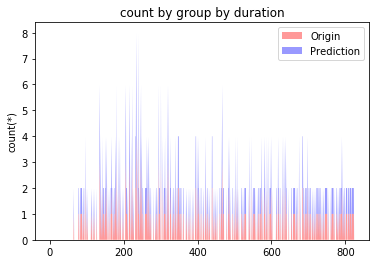

In [28]:
final_group_age=final_result.groupBy(final_result['duration'].alias("x")).agg(sum("d_y").alias("Origin_Yes_Count"),sum("final_prediction").alias("Prediction_Yes_Count")).sort("x").toPandas()  
showLines_bars2(final_group_age,'duration')

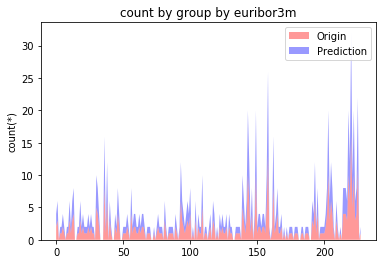

In [29]:
final_group_emp=final_result.groupBy(final_result['euribor3m'].alias("x")).agg(sum("d_y").alias("Origin_Yes_Count"),sum("final_prediction").alias("Prediction_Yes_Count")).sort("x").toPandas()  
showLines_bars2(final_group_emp,'euribor3m')

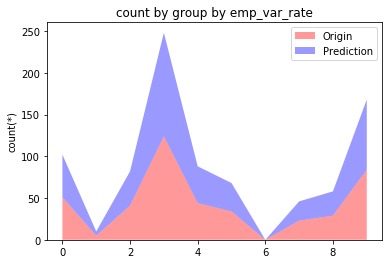

In [30]:
final_group_emp=final_result.groupBy(final_result['emp_var_rate'].alias("x")).agg(sum("d_y").alias("Origin_Yes_Count"),sum("final_prediction").alias("Prediction_Yes_Count")).sort("x").toPandas()  
showLines_bars2(final_group_emp,'emp_var_rate')

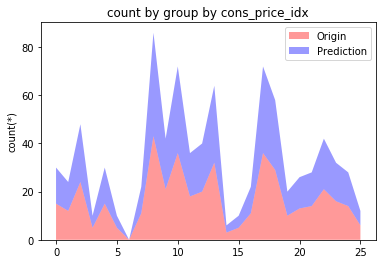

In [31]:
final_group_emp=final_result.groupBy(final_result['cons_price_idx'].alias("x")).agg(sum("d_y").alias("Origin_Yes_Count"),sum("final_prediction").alias("Prediction_Yes_Count")).sort("x").toPandas()
showLines_bars2(final_group_emp,'cons_price_idx')

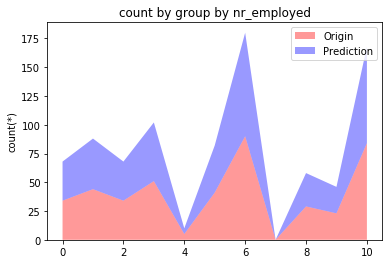

In [32]:
final_group_emp=final_result.groupBy(final_result['nr_employed'].alias("x")).agg(sum("d_y").alias("Origin_Yes_Count"),sum("final_prediction").alias("Prediction_Yes_Count")).sort("x").toPandas()  
showLines_bars2(final_group_emp,'nr_employed')

In [33]:
final_compare=final_result.groupBy("d_y","final_prediction").agg(count("age").alias("record_count")).sort("d_y","final_prediction")
final_compare =final_compare.withColumn("Y-N",when(((col('d_y')==1 )& (col('final_prediction')==1.0)) ,'Yes-Yes').otherwise(when(((col('d_y')==1)& (col('final_prediction')==0.0 ) ),'Yes-No').otherwise(when(col('final_prediction')==1.0,'No-Yes').otherwise('No-No'))))
final_compare=final_compare.toPandas()

In [34]:
ttl_recordCount=final_result.count()

In [35]:
final_compare["ratio"]=final_compare["record_count"]*100.0/ttl_recordCount

In [36]:
final_compare 

,d_y,final_prediction,record_count,Y-N,ratio
0,0,0.0,2612,No-No,67.198353
1,0,1.0,840,No-Yes,21.610497
2,1,0.0,20,Yes-No,0.514536
3,1,1.0,415,Yes-Yes,10.676614


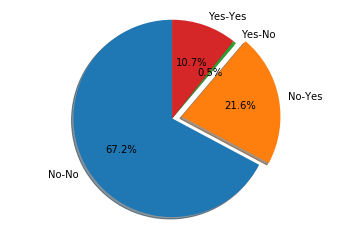

In [37]:
 

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels =final_compare["Y-N"].values.tolist()
sizes = final_compare["ratio"].values.tolist()
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()